<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# EP2 - RNN's Bidirecionais, Underfitting & Overfitting
**Nome:** Davy Alves de Souza

**Numero Usp:** 11561247

O objetivo deste exercício é aumentar a familiarização dos alunos com **redes neurais recorrentes bidirecionais**, em arquiteturas **LSTM** e **GRU** e uma aplicação em análise de sentimentos. Além disso pretendemos abordar dois problemas muito comuns em aprendizado de máquina, a saber, o problema do subajuste (*underfitting*) e do
sobreajuste (*overfitting*) e de técnicas para evitar o problema do sobreajuste, como a utilização de uma camada
*Dropout* durante o treinamento e a divisão do córpus em três conjuntos: dados de treinamento, dados de validação
e dados de teste.

## Setup

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt
%matplotlib inline

tf.__version__

'2.3.1'

In [2]:
# constants
max_tokens = 20000  # we will consider only the top 20k words
output_len = 64     # truncate or pad the sequences to get this length
batch_size = 128    # batch size


# some datasets that can be used
b2w_10k_dataset_path  = "../data/b2w-10k.csv"
b2w_full_dataset_path = "../data/B2W-Reviews01.csv"


# some word embeddings
cbow_s50_path   = "../data/cbow_s50.txt"
cbow_s100_path  = "../data/cbow_s100.txt"
cbow_s300_path  = "../data/cbow_s300.txt"
cbow_s600_path  = "../data/cbow_s600.txt"
cbow_s1000_path = "../data/cbow_s1000.txt"


# classes
class_names = ["Unknown", "Pessimo", "Ruim", "OK", "Bom", "Otimo"]

## Pré-processamento de Dados

Vamos criar um *pipeline* que automáticamente extrai os dados de uma planilha CSV, gera os corpos de treinamento, validação e teste, cria os iteradores que vão compor os *batches* que serão alimentados na entrada do sistema, codificando as palavras de acordo com algum esquema de vetorização.

Utilizaremos o córpus de avaliações da B2W e estamos interessados em apenas duas colunas: `review_text` e `overall_rating`.

Passos do *pipeline*:
 - **Filtro**: Filtrar todas as linhas cujo rótulo não é um valor numérico entre 0 e 5.
 - **Partilha**: Recebe o nome do arquivo CSV contendo o *dataset* de entrada, e o nome do diretório de saída, e as proporções dos *datasets* de avaliação e de teste. A partir dos dados filtrados, altera aleatóriamente sua ordem e gera planilhas CSV de **treinamento**, **validação** e **teste** nas proporções:
     - Treinamento :65%
     - Validação: 10%
     - Teste: 25%
 - **Codifica**: Utilizar um codificador de palavras para vetor de dados de *d-dimensional*.

In [3]:
# Filtra

# read a CSV file into a DataFrame
b2wCorpus = pd.read_csv(b2w_10k_dataset_path)

# selecting columns
processed_data = b2wCorpus[['review_text', 'overall_rating']]

# dropping NaN values
processed_data = processed_data.dropna()

print("Found %5d samples of class 0" % len(processed_data[processed_data['overall_rating'] == 0]))
print("Found %5d samples of class 1" % len(processed_data[processed_data['overall_rating'] == 1]))
print("Found %5d samples of class 2" % len(processed_data[processed_data['overall_rating'] == 2]))
print("Found %5d samples of class 3" % len(processed_data[processed_data['overall_rating'] == 3]))
print("Found %5d samples of class 4" % len(processed_data[processed_data['overall_rating'] == 4]))
print("Found %5d samples of class 5" % len(processed_data[processed_data['overall_rating'] == 5]))

processed_data.head()

Found     0 samples of class 0
Found  1918 samples of class 1
Found   618 samples of class 2
Found  1216 samples of class 3
Found  2503 samples of class 4
Found  3744 samples of class 5


,review_text,overall_rating
0,Estou contente com a compra entrega rápida o ú...,4
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4
4,"A entrega foi no prazo, as americanas estão de...",5


In [4]:
# Partilha

# Shuffle data
processed_data = processed_data.sample(frac=1).reset_index(drop=True)

# Split data
train, validate, test = np.split(processed_data, [int(.65 * len(processed_data)), int(.75 * len(processed_data))])

num_samples          = len(processed_data['review_text'])
num_train_samples    = len(train['review_text'])
num_validate_samples = len(validate['review_text'])
num_test_samples     = len(test['review_text'])

print("Total of samples found: %d" % num_samples)

print("Total of training samples found: %d (%d%%)" % 
      (num_train_samples, round(num_train_samples / num_samples * 100)))

print("Total of validation samples found : %d (%d%%)" % 
      (num_validate_samples, round(num_validate_samples / num_samples * 100)))

print("Total of testing samples found: %d (%d%%)" % 
      (num_test_samples, round(num_test_samples / num_samples * 100)))

# Saving CSV files of training, validation and testing datasets
train.to_csv(r'b2w-train.csv', index = False, header=True)
validate.to_csv(r'b2w-validate.csv', index = False, header=True)
test.to_csv(r'b2w-test.csv', index = False, header=True)

Total of samples found: 9999
Total of training samples found: 6499 (65%)
Total of validation samples found : 1000 (10%)
Total of testing samples found: 2500 (25%)


In [5]:
print('Training data: ')
print(' - Class 1: %4d samples (%2d%%)' % (len(train[train['overall_rating'] == 1]), len(train[train['overall_rating'] == 1]) / len(train) * 100))
print(' - Class 2: %4d samples (%2d%%)' % (len(train[train['overall_rating'] == 2]), len(train[train['overall_rating'] == 2]) / len(train) * 100))
print(' - Class 3: %4d samples (%2d%%)' % (len(train[train['overall_rating'] == 3]), len(train[train['overall_rating'] == 3]) / len(train) * 100))
print(' - Class 4: %4d samples (%2d%%)' % (len(train[train['overall_rating'] == 4]), len(train[train['overall_rating'] == 4]) / len(train) * 100))
print(' - Class 5: %4d samples (%2d%%)\n' % (len(train[train['overall_rating'] == 5]), len(train[train['overall_rating'] == 5]) / len(train) * 100))

print('Validation data: ')
print(' - Class 1: %4d samples (%2d%%)' % (len(validate[validate['overall_rating'] == 1]), len(validate[validate['overall_rating'] == 1]) / len(validate) * 100))
print(' - Class 2: %4d samples (%2d%%)' % (len(validate[validate['overall_rating'] == 2]), len(validate[validate['overall_rating'] == 2]) / len(validate) * 100))
print(' - Class 3: %4d samples (%2d%%)' % (len(validate[validate['overall_rating'] == 3]), len(validate[validate['overall_rating'] == 3]) / len(validate) * 100))
print(' - Class 4: %4d samples (%2d%%)' % (len(validate[validate['overall_rating'] == 4]), len(validate[validate['overall_rating'] == 4]) / len(validate) * 100))
print(' - Class 5: %4d samples (%2d%%)' % (len(validate[validate['overall_rating'] == 5]), len(validate[validate['overall_rating'] == 5]) / len(validate) * 100))

Training data: 
 - Class 1: 1248 samples (19%)
 - Class 2:  400 samples ( 6%)
 - Class 3:  806 samples (12%)
 - Class 4: 1625 samples (25%)
 - Class 5: 2420 samples (37%)

Validation data: 
 - Class 1:  198 samples (19%)
 - Class 2:   64 samples ( 6%)
 - Class 3:  123 samples (12%)
 - Class 4:  237 samples (23%)
 - Class 5:  378 samples (37%)


In [6]:
# Codifica
x_train = train['review_text']
y_train = train['overall_rating']

x_validate = validate['review_text']
y_validate = validate['overall_rating']

x_test = test['review_text']
y_test = test['overall_rating']

# vectorizing text into value array
# top 20k words
# trucante or pad = 200
vectorizer = layers.experimental.preprocessing.TextVectorization(max_tokens=max_tokens, output_sequence_length=output_len)
text_ds = tf.data.Dataset.from_tensor_slices(processed_data['review_text']).batch(batch_size)
vectorizer.adapt(text_ds)

In [7]:
# Get vocabulary from vectorizer 
vocabulary = vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)

print("Vocabulary size: %d" % vocabulary_size)

# Create a word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

Vocabulary size: 14991


In [8]:
word2vec_path = "word2vec_200k.txt"

# Pré-processa embedding
N =  200001
with open(cbow_s50_path, "r", encoding="utf8") as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open(word2vec_path, "w", encoding="utf8") as file:
    for line in head:
        file.write(line)

In [9]:
# Load pre-trained word embeddings
embeddings_index = {}
with open(word2vec_path, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 200000 word vectors.


In [10]:
# embeddings_index[',']
# word_index

In [11]:
num_tokens = vocabulary_size + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and embedding_vector.size == embedding_dim:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 10906 words (4085 misses)


In [12]:
# embedding_matrix[25]

In [13]:
embedding_layer = layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False
)

## Treinamento

In [14]:
# LSTM
# inputs = keras.Input(shape=(None,), dtype=tf.int64)

# embedded_sequences = embedding_layer(inputs)
# x = layers.SpatialDropout1D(.1)(embedded_sequences)
# x = layers.LSTM(64)(x)
# outputs = layers.Dense(len(class_names), activation="softmax")(x)

# model = keras.Model(inputs=inputs, outputs=outputs)

# Bidirectional LSTM
inputs = keras.Input(shape=(None,), dtype=tf.int64)

embedded_sequences = embedding_layer(inputs)
x = layers.SpatialDropout1D(.1)(embedded_sequences)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


# model = tf.keras.Sequential()
# model.add(Embedding(num_tokens,
#                     embedding_dim,
#                     embeddings_initializer=keras.initializers.Constant(embedding_matrix),
#                     input_length=200,
#                     trainable=True))
# model.add(layers.SpatialDropout1D(.2))
# model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
# model.add(layers.Bidirectional(layers.LSTM(32)))
# model.add(layers.Dropout(.25))
# model.add(layers.Dense(units=len(class_names), activation='softmax'))


# int_sequences_input = keras.Input(shape=(None,), dtype="int64")
# embedded_sequences = embedding_layer(int_sequences_input)
# x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
# x = layers.MaxPooling1D(5)(x)
# x = layers.Conv1D(128, 5, activation="relu")(x)
# x = layers.MaxPooling1D(5)(x)
# x = layers.Conv1D(128, 5, activation="relu")(x)
# x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.5)(x)
# preds = layers.Dense(len(class_names), activation="softmax")(x)
# model = keras.Model(int_sequences_input, preds)



# model = tf.keras.Sequential([
#     tf.keras.Input(shape=(1,), dtype=tf.string),
    
#     tf.keras.layers.experimental.preprocessing.TextVectorization(standardize="lower_and_strip_punctuation",
#                                                                  split="whitespace",
#                                                                  output_mode="int"),
    
#     tf.keras.layers.Embedding(num_tokens, 600),
    
#     tf.keras.layers.Dropout(.1),
#     tf.keras.layers.LSTM(256),
#     tf.keras.layers.Dropout(.3),
    
#     tf.keras.layers.Dense(len(class_names), activation='softmax')
# ])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 50)          749650    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 50)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 809,304
Trainable params: 59,654
Non-trainable params: 749,650
_________________________________________________________________


In [15]:
x_train_embedded = vectorizer(np.array([[s] for s in x_train])).numpy()
y_train_embedded = np.array(y_train)

x_validate_embedded = vectorizer(np.array([[s] for s in x_validate])).numpy()
y_validate_embedded = np.array(y_validate)

x_test_embedded = vectorizer(np.array([[s] for s in x_test])).numpy()
y_test_embedded = np.array(y_test)

# x_train_embedded 
# y_train_embedded

# x_validate_embedded
# y_validate_embedded
x_train_embedded

array([[  29,    6,   17, ...,    0,    0,    0],
       [   6,    9,   15, ...,    0,    0,    0],
       [ 898,  380,   75, ...,    0,    0,    0],
       ...,
       [ 416,   72, 3020, ...,    0,    0,    0],
       [   2,    6,   20, ...,    0,    0,    0],
       [   6,   58,  133, ...,    0,    0,    0]], dtype=int64)

In [16]:
checkpoint_filepath = 'model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
model_checkpoint_callback = callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                      save_weights_only=True,
                                                      monitor='val_loss',
                                                      mode='min',
                                                      save_best_only=True)


model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train_embedded, 
                    y_train_embedded, 
                    batch_size=batch_size, 
                    epochs=15, 
                    validation_data=(x_validate_embedded, y_validate_embedded),
                    callbacks=[model_checkpoint_callback]
                   )

# model.fit(x_train, 
#           y_train, 
#           batch_size=batch_size, 
#           epochs=10, 
#           validation_data=(x_validate, y_validate)
#          )

Epoch 1/15
51/51 [==============================] - 1s 26ms/step - loss: 1.5108 - accuracy: 0.3744 - val_loss: 1.3851 - val_accuracy: 0.4210
Epoch 2/15
51/51 [==============================] - 0s 9ms/step - loss: 1.2897 - accuracy: 0.4616 - val_loss: 1.2726 - val_accuracy: 0.4770
Epoch 3/15
51/51 [==============================] - 0s 9ms/step - loss: 1.2360 - accuracy: 0.4835 - val_loss: 1.2395 - val_accuracy: 0.4940
Epoch 4/15
51/51 [==============================] - 0s 9ms/step - loss: 1.2075 - accuracy: 0.4899 - val_loss: 1.2141 - val_accuracy: 0.5050
Epoch 5/15
51/51 [==============================] - 1s 10ms/step - loss: 1.1891 - accuracy: 0.4932 - val_loss: 1.2058 - val_accuracy: 0.5030
Epoch 6/15
51/51 [==============================] - 0s 9ms/step - loss: 1.1720 - accuracy: 0.5042 - val_loss: 1.1905 - val_accuracy: 0.5120
Epoch 7/15
51/51 [==============================] - 0s 9ms/step - loss: 1.1601 - accuracy: 0.5092 - val_loss: 1.1790 - val_accuracy: 0.5240
Epoch 8/15
51/51 [

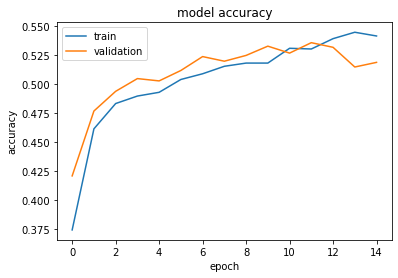

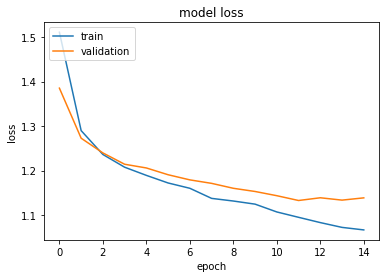

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Validação

In [25]:
import json

print(history.history['val_loss'])

print(min(history.history['val_loss']))
print(history.history['val_loss'].index(min(history.history['val_loss'])))


with open('history.txt', "w", encoding="utf8") as file:
    file.write(json.dumps(history.history, indent=4))



[1.3850998878479004, 1.2726017236709595, 1.2395497560501099, 1.2141228914260864, 1.2057626247406006, 1.1905333995819092, 1.178985834121704, 1.1711783409118652, 1.1600979566574097, 1.152916431427002, 1.1434457302093506, 1.1326472759246826, 1.138780951499939, 1.1335033178329468, 1.1385849714279175]
1.1326472759246826
11


## Teste

In [19]:
model.evaluate(x=x_test_embedded,y=y_test_embedded)

79/79 [==============================] - 0s 3ms/step - loss: 1.1188 - accuracy: 0.5212


[1.1187989711761475, 0.5212000012397766]

In [20]:
# model.load_weights('model.epoch02-loss0.91.hdf5')

In [21]:
# model.evaluate(x=x_test_embedded,y=y_test_embedded)